# RAG Over PDFs with ColNomic Embed Multimodal

![banner image](https://assets.nomicatlas.com/pdf-rag-colnomic-embed-multimodal.png)

ColNomic Embed Multimodal is a late interaction embedding model that processes both text and images. It can directly process the visual content in PDFs without requiring preprocessing steps like OCR or image captioning.

In this notebook, we demonstrate how to build multimodal RAG that can answer questions from PDFs containing both text and visual elements.

**Note: due to the use of Flash Attention in this notebook, compatible GPUs such as the Ampere series (A10, A100, etc) are required. It should cost you < $1 in Colab compute credits on an A100.**

## Setup

Make sure the required libraries are installed. Note that we use the Nomic fork of `byaldi` (for compatibility with the new `colnomic-embed-multimodal` model).

In [1]:
!sudo apt-get install --quiet -y poppler-utils

Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.8 [186 kB]
Fetched 186 kB in 0s (1,186 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package poppler-utils.
(Reading database ... 126281 files and dir

In [2]:
!pip install -q git+https://github.com/nomic-ai/byaldi.git git+https://github.com/illuin-tech/colpali.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.9/517.9 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.1/411.1 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.8 MB/s eta 0:00:00
   ━━━━━━

In [3]:
!pip install flash-attn==2.5.8

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 25.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for flash-attn: filename=flash_attn-2.5.8-cp311-cp311-linux_x86_64.whl size=119197192 sha256=f4517ccb31b280e7b09371b01503aaa4caf717b51ac2d513c03649909ceef488
  Stored in directory: /root/.cache/pip/wheels/2a/88/b2/587b498e2caa887707a63d0ed7d7f4beca27f5034640382845
Successfully built flash-attn


In [ ]:
!pip install -q git+https://github.com/huggingface/transformers qwen-vl-utils[decord]==0.0.8 accelerate flash-attn==2.5.8 matplotlib pdf2image

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 25.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━

## Preview PDF

We are going to use a pdf of data from the US Department of Labor you can download running the following command or by visiting the link [here](https://assets.nomicatlas.com/department-of-labor-data.pdf).

In [1]:
!curl -o department-of-labor-data.pdf https://assets.nomicatlas.com/department-of-labor-data.pdf

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  586k  100  586k    0     0  2142k      0 --:--:-- --:--:-- --:--:-- 2149k


In [2]:
import matplotlib.pyplot as plt
from pdf2image import convert_from_path

def display_pdf_images(images_list):
    """Display all images in the provided list as subplots with 5 images per row."""
    num_images = len(images_list)
    num_rows = num_images // 5 + (1 if num_images % 5 > 0 else 0)
    fig, axes = plt.subplots(num_rows, 5, figsize=(20, 4 * num_rows))
    if num_rows == 1:
        axes = [axes] if num_images == 1 else axes
    else:
        axes = axes.flatten()
    for i, img in enumerate(images_list):
        if i < len(axes):
            ax = axes[i]
            ax.imshow(img)
            ax.set_title(f"Page {i+1}")
            ax.axis('off')
    for j in range(num_images, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()

pdf_images = convert_from_path("department-of-labor-data.pdf")

display_pdf_images(pdf_images)

ModuleNotFoundError: No module named 'pdf2image'

## Create RAG Index

We create a RAG index over the PDF using the [`byaldi`](https://github.com/AnswerDotAI/byaldi) library with `colnomic-embed-multimodal` as our retriever.

**Note: This is *much* faster on GPU than CPU.**

In [ ]:
from byaldi import RAGMultiModalModel

RAG = RAGMultiModalModel.from_pretrained(
    "nomic-ai/colnomic-embed-multimodal-3b",
    device="cuda:0"
)

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


adapter_config.json:   0%|          | 0.00/805 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.37k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/65.4k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.53G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of ColQwen2_5 were not initialized from the model checkpoint at Qwen/Qwen2.5-VL-3B-Instruct and are newly initialized: ['custom_text_proj.bias', 'custom_text_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/240M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/7.41k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

Some kwargs in processor config are unused and will not have any effect: max_num_visual_tokens. 


In [ ]:
RAG.index(
    input_path="department-of-labor-data.pdf",
    index_name="image_index",
    store_collection_with_index=False,
    overwrite=True
)

Added page 1 of document 0 to index.
Added page 2 of document 0 to index.
Added page 3 of document 0 to index.
Added page 4 of document 0 to index.
Added page 5 of document 0 to index.
Added page 6 of document 0 to index.
Added page 7 of document 0 to index.
Added page 8 of document 0 to index.
Added page 9 of document 0 to index.
Index exported to .byaldi/image_index
Index exported to .byaldi/image_index


{0: 'department-of-labor-data.pdf'}

## Setup Retrieval and VLM Querying

The `query_image` function uses a vision-language model (VLM) to ask a question of an image, which we will use to answer the user query.

In [ ]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
from PIL.Image import Image

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-7B-Instruct",
    torch_dtype="auto",
    device_map="auto"
)
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct")

def query_vlm(query: str, images: list[Image]) -> str:
    """Queries Qwen VLM with text and images"""
    system_prompt = "You are an expert professional PDF analyst who gives rigorous in-depth answers."
    message_content = [
        {"type": "image", "image": image}
        for image in images
    ] + [{"type": "text", "text": query}]
    messages = [
        {
            "role": "system",
            "content": [{"type": "text", "text": system_prompt}]
        },
        {
            "role": "user",
            "content": message_content
        }
    ]
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt"
    ).to(model.device)
    generated_ids = model.generate(**inputs, max_new_tokens=1000)
    generated_ids_trimmed = generated_ids[0][len(inputs.input_ids[0]):]
    return processor.decode(generated_ids_trimmed, skip_special_tokens=True)

config.json:   0%|          | 0.00/1.37k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/57.6k [00:00<?, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

## Plotting Helper Function

In [ ]:
import textwrap
from matplotlib import gridspec
import numpy as np

def plot_rag_result(query: str, answer: str, images: list[Image]) -> None:
    """Plots user query, retrieved source doc as image(s), and VLM answer"""
    wrapped_query = '\n'.join(textwrap.wrap(query, width=70))
    num_images = len(images)
    fig = plt.figure(figsize=(14, 10))
    outer = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.1)
    if num_images == 1:
        ax1 = fig.add_subplot(outer[0])
        ax1.imshow(images[0])
        ax1.axis('off')
        ax1.set_title("Source Document\nretrieved by ColNomic Embed Multimodal",
                      fontsize=12, fontweight='bold', loc='left', pad=0)
    else:
        left = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[0])
        fig.text(0.1, 0.9, "Source Documents\nretrieved by ColNomic Embed Multimodal",
                fontsize=12, fontweight='bold', va='top', ha='left')
        if num_images == 2:
            rows, cols = 1, 2
        else:
            cols = min(int(np.ceil(np.sqrt(num_images))), 3)
            rows = int(np.ceil(num_images / cols))
        inner = gridspec.GridSpecFromSubplotSpec(rows, cols, subplot_spec=left[0],
                                                wspace=0.05, hspace=0.05)
        for i, image in enumerate(images):
            ax_sub = fig.add_subplot(inner[i])
            ax_sub.imshow(image)
            ax_sub.axis('off')
    ax2 = fig.add_subplot(outer[1])
    ax2.axis('off')
    ax2.set_title("Answer generated by Qwen 2.5 VL 7B Instruct", fontsize=12, fontweight='bold', loc='left')
    wrapped_answer = '\n'.join(['\n'.join(textwrap.wrap(line, width=70)) for line in answer.split('\n')])
    fontsize = 9
    if len(wrapped_answer) > 1500:
        fontsize = 8
        if len(wrapped_answer) > 2500:
          fontsize = 7

    ax2.text(0.02, 0.97, wrapped_answer, transform=ax2.transAxes, fontsize=fontsize, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='#2C3E50', linewidth=2, pad=1.0))
    fig.suptitle(f"Query: {wrapped_query}", fontsize=14, fontweight='bold', y=0.96)
    plt.show()

# Single Document Retrieval

In [ ]:
single_doc_query = "Which states showed a decrease in unadjusted initial claims the week ending January 18, 2025?"
single_doc_rag_results = RAG.search(single_doc_query, k=1)
single_doc_image = pdf_images[single_doc_rag_results[0]["page_num"] - 1]
single_doc_answer = query_vlm(single_doc_query, [single_doc_image])

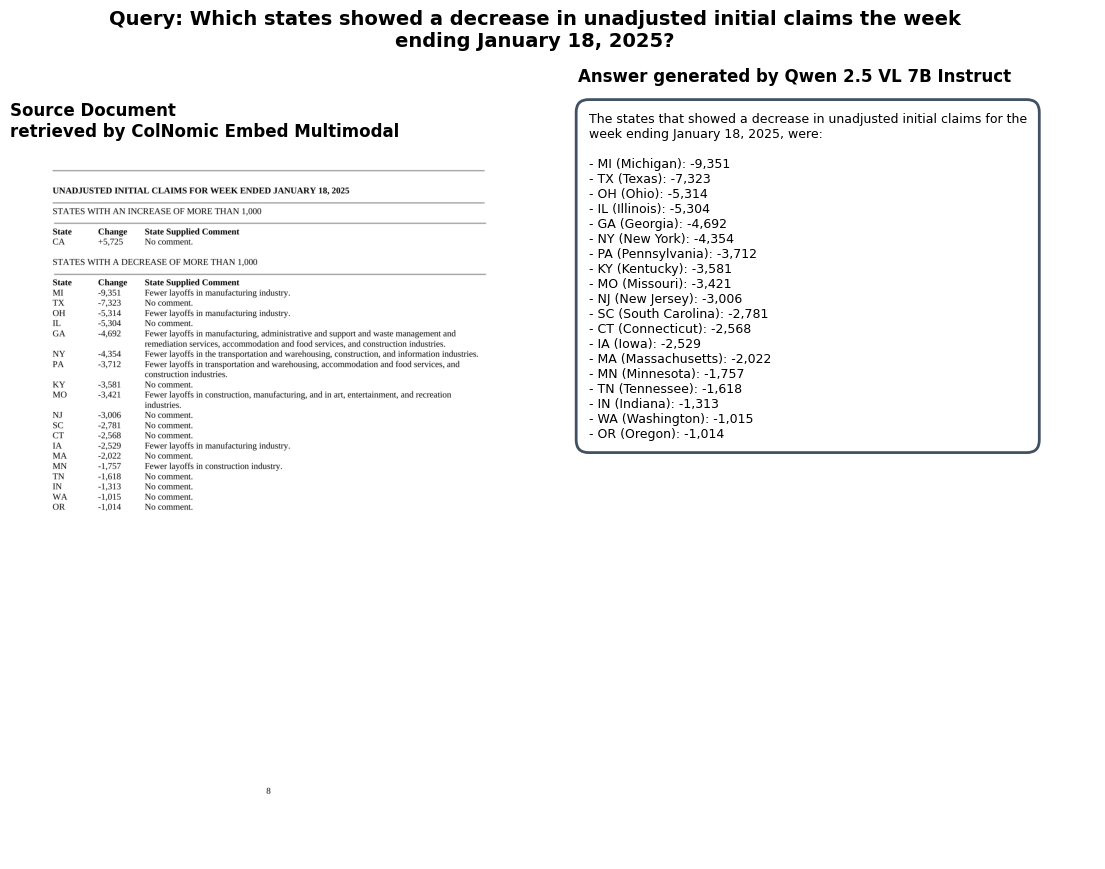

In [ ]:
plot_rag_result(single_doc_query, single_doc_answer, [single_doc_image])

Now we'll display the page in more detail so you can see how the model's answers align with the retrieved source page.

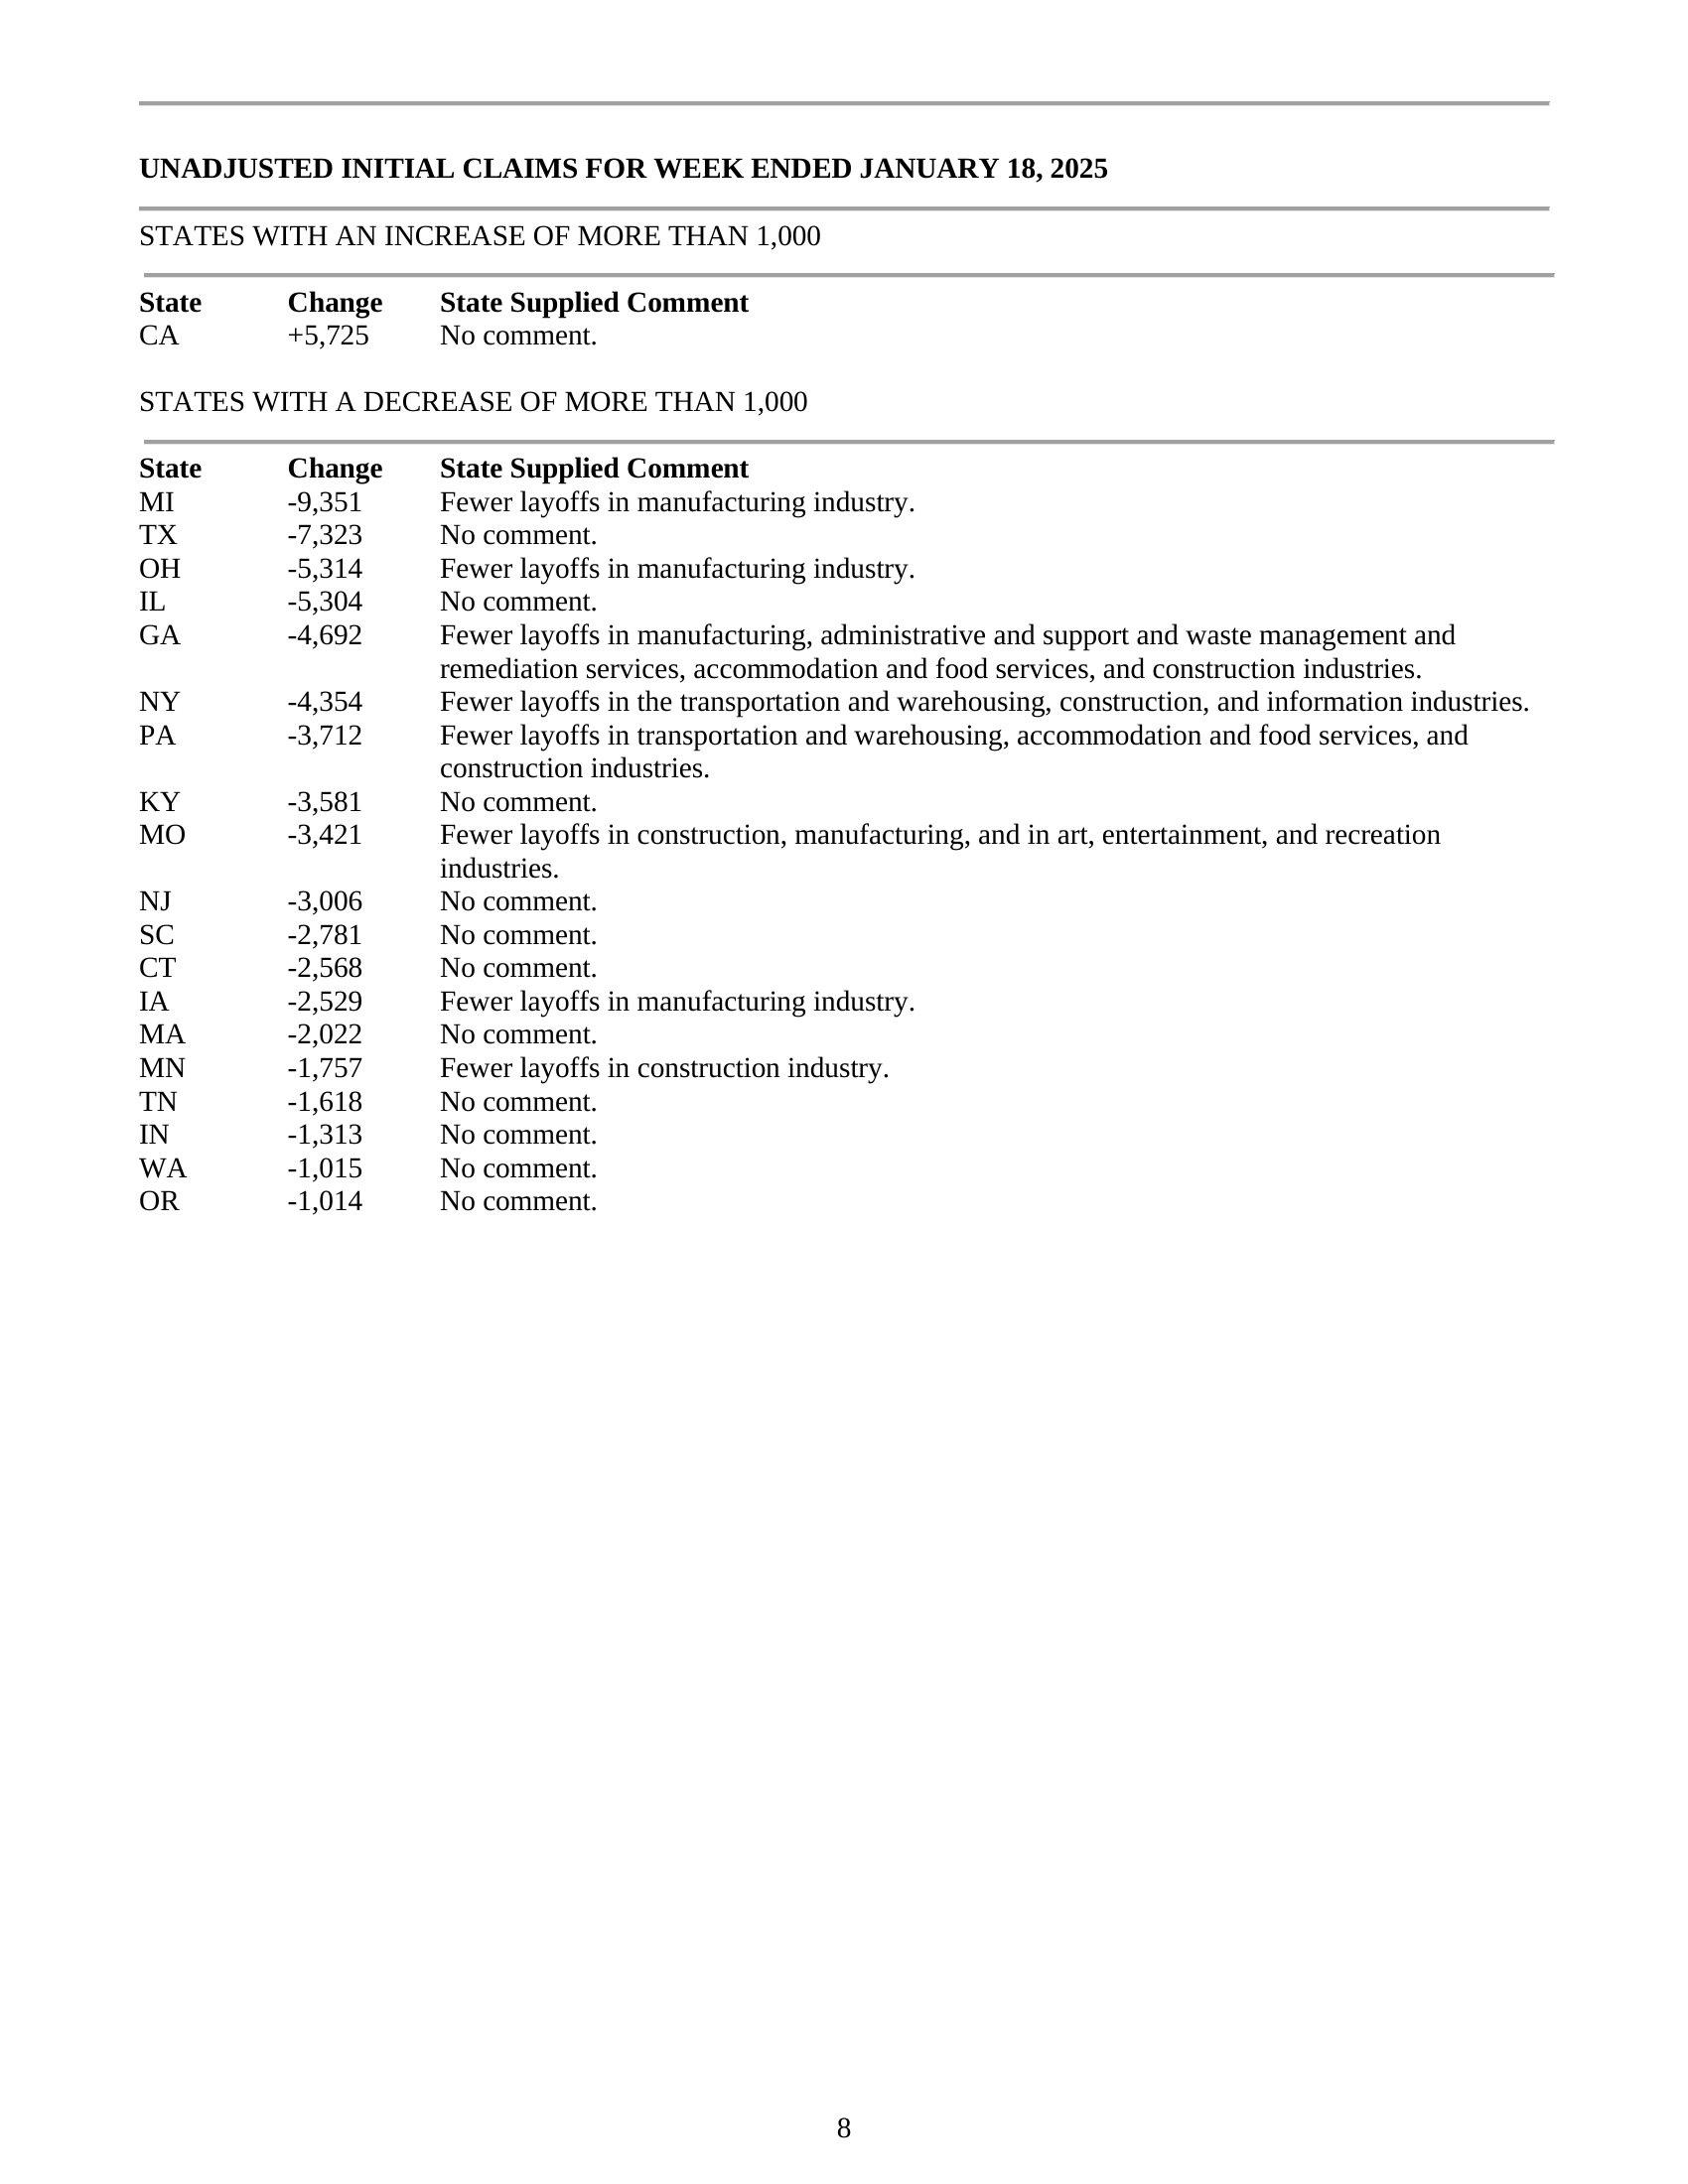

In [ ]:
single_doc_image

In [ ]:
print(single_doc_answer)

The states that showed a decrease in unadjusted initial claims for the week ending January 18, 2025, were:

- MI (Michigan): -9,351
- TX (Texas): -7,323
- OH (Ohio): -5,314
- IL (Illinois): -5,304
- GA (Georgia): -4,692
- NY (New York): -4,354
- PA (Pennsylvania): -3,712
- KY (Kentucky): -3,581
- MO (Missouri): -3,421
- NJ (New Jersey): -3,006
- SC (South Carolina): -2,781
- CT (Connecticut): -2,568
- IA (Iowa): -2,529
- MA (Massachusetts): -2,022
- MN (Minnesota): -1,757
- TN (Tennessee): -1,618
- IN (Indiana): -1,313
- WA (Washington): -1,015
- OR (Oregon): -1,014


# Multi Document Retrieval

In [ ]:
multi_doc_query = "I want an in-depth report on how charts for seasonally adjusted claims show differences from charts for unadjusted claims."
K = 2
multi_doc_rag_results = RAG.search(multi_doc_query, k=K)
multi_doc_images = [pdf_images[multi_doc_rag_results[i]["page_num"] - 1] for i in range(K)]
multi_doc_answer = query_vlm(multi_doc_query, multi_doc_images)

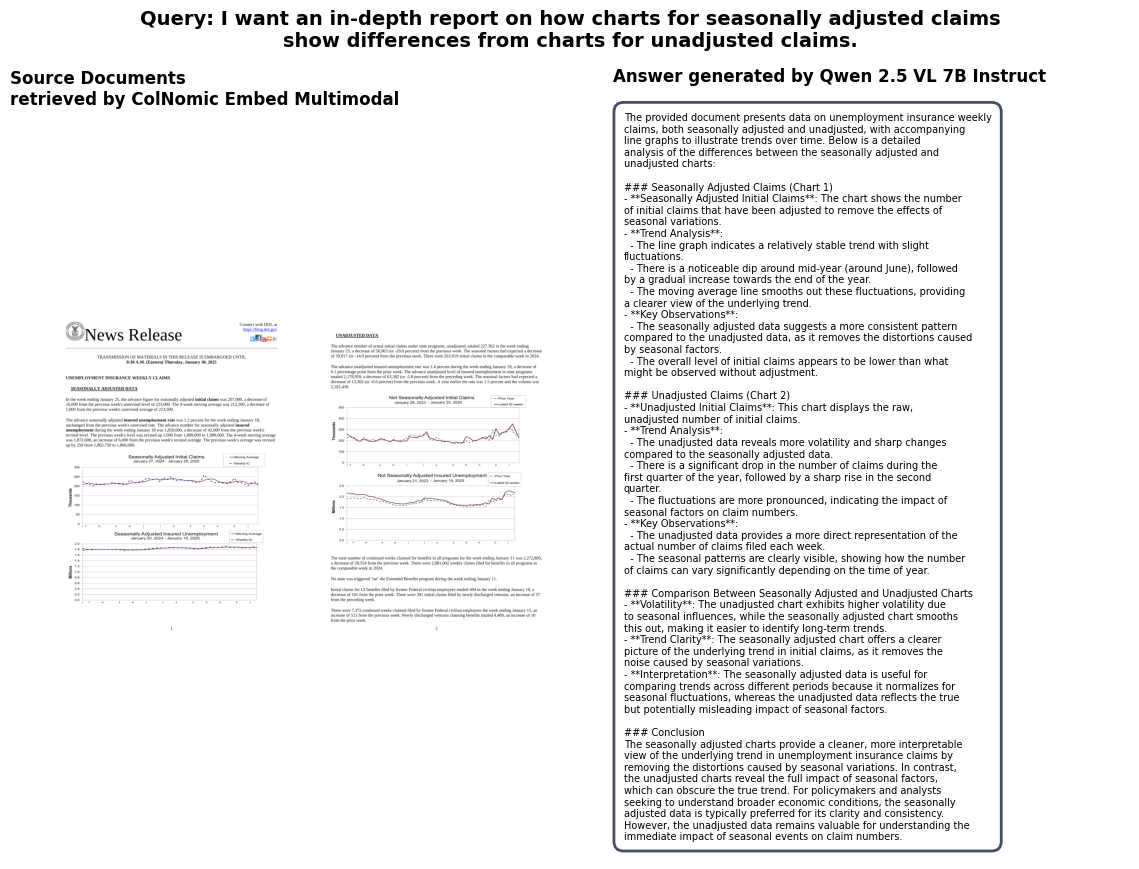

In [ ]:
plot_rag_result(multi_doc_query, multi_doc_answer, multi_doc_images)

Now we'll display the pages in more detail so you can see how the model's answers align with the retrieved source pages.

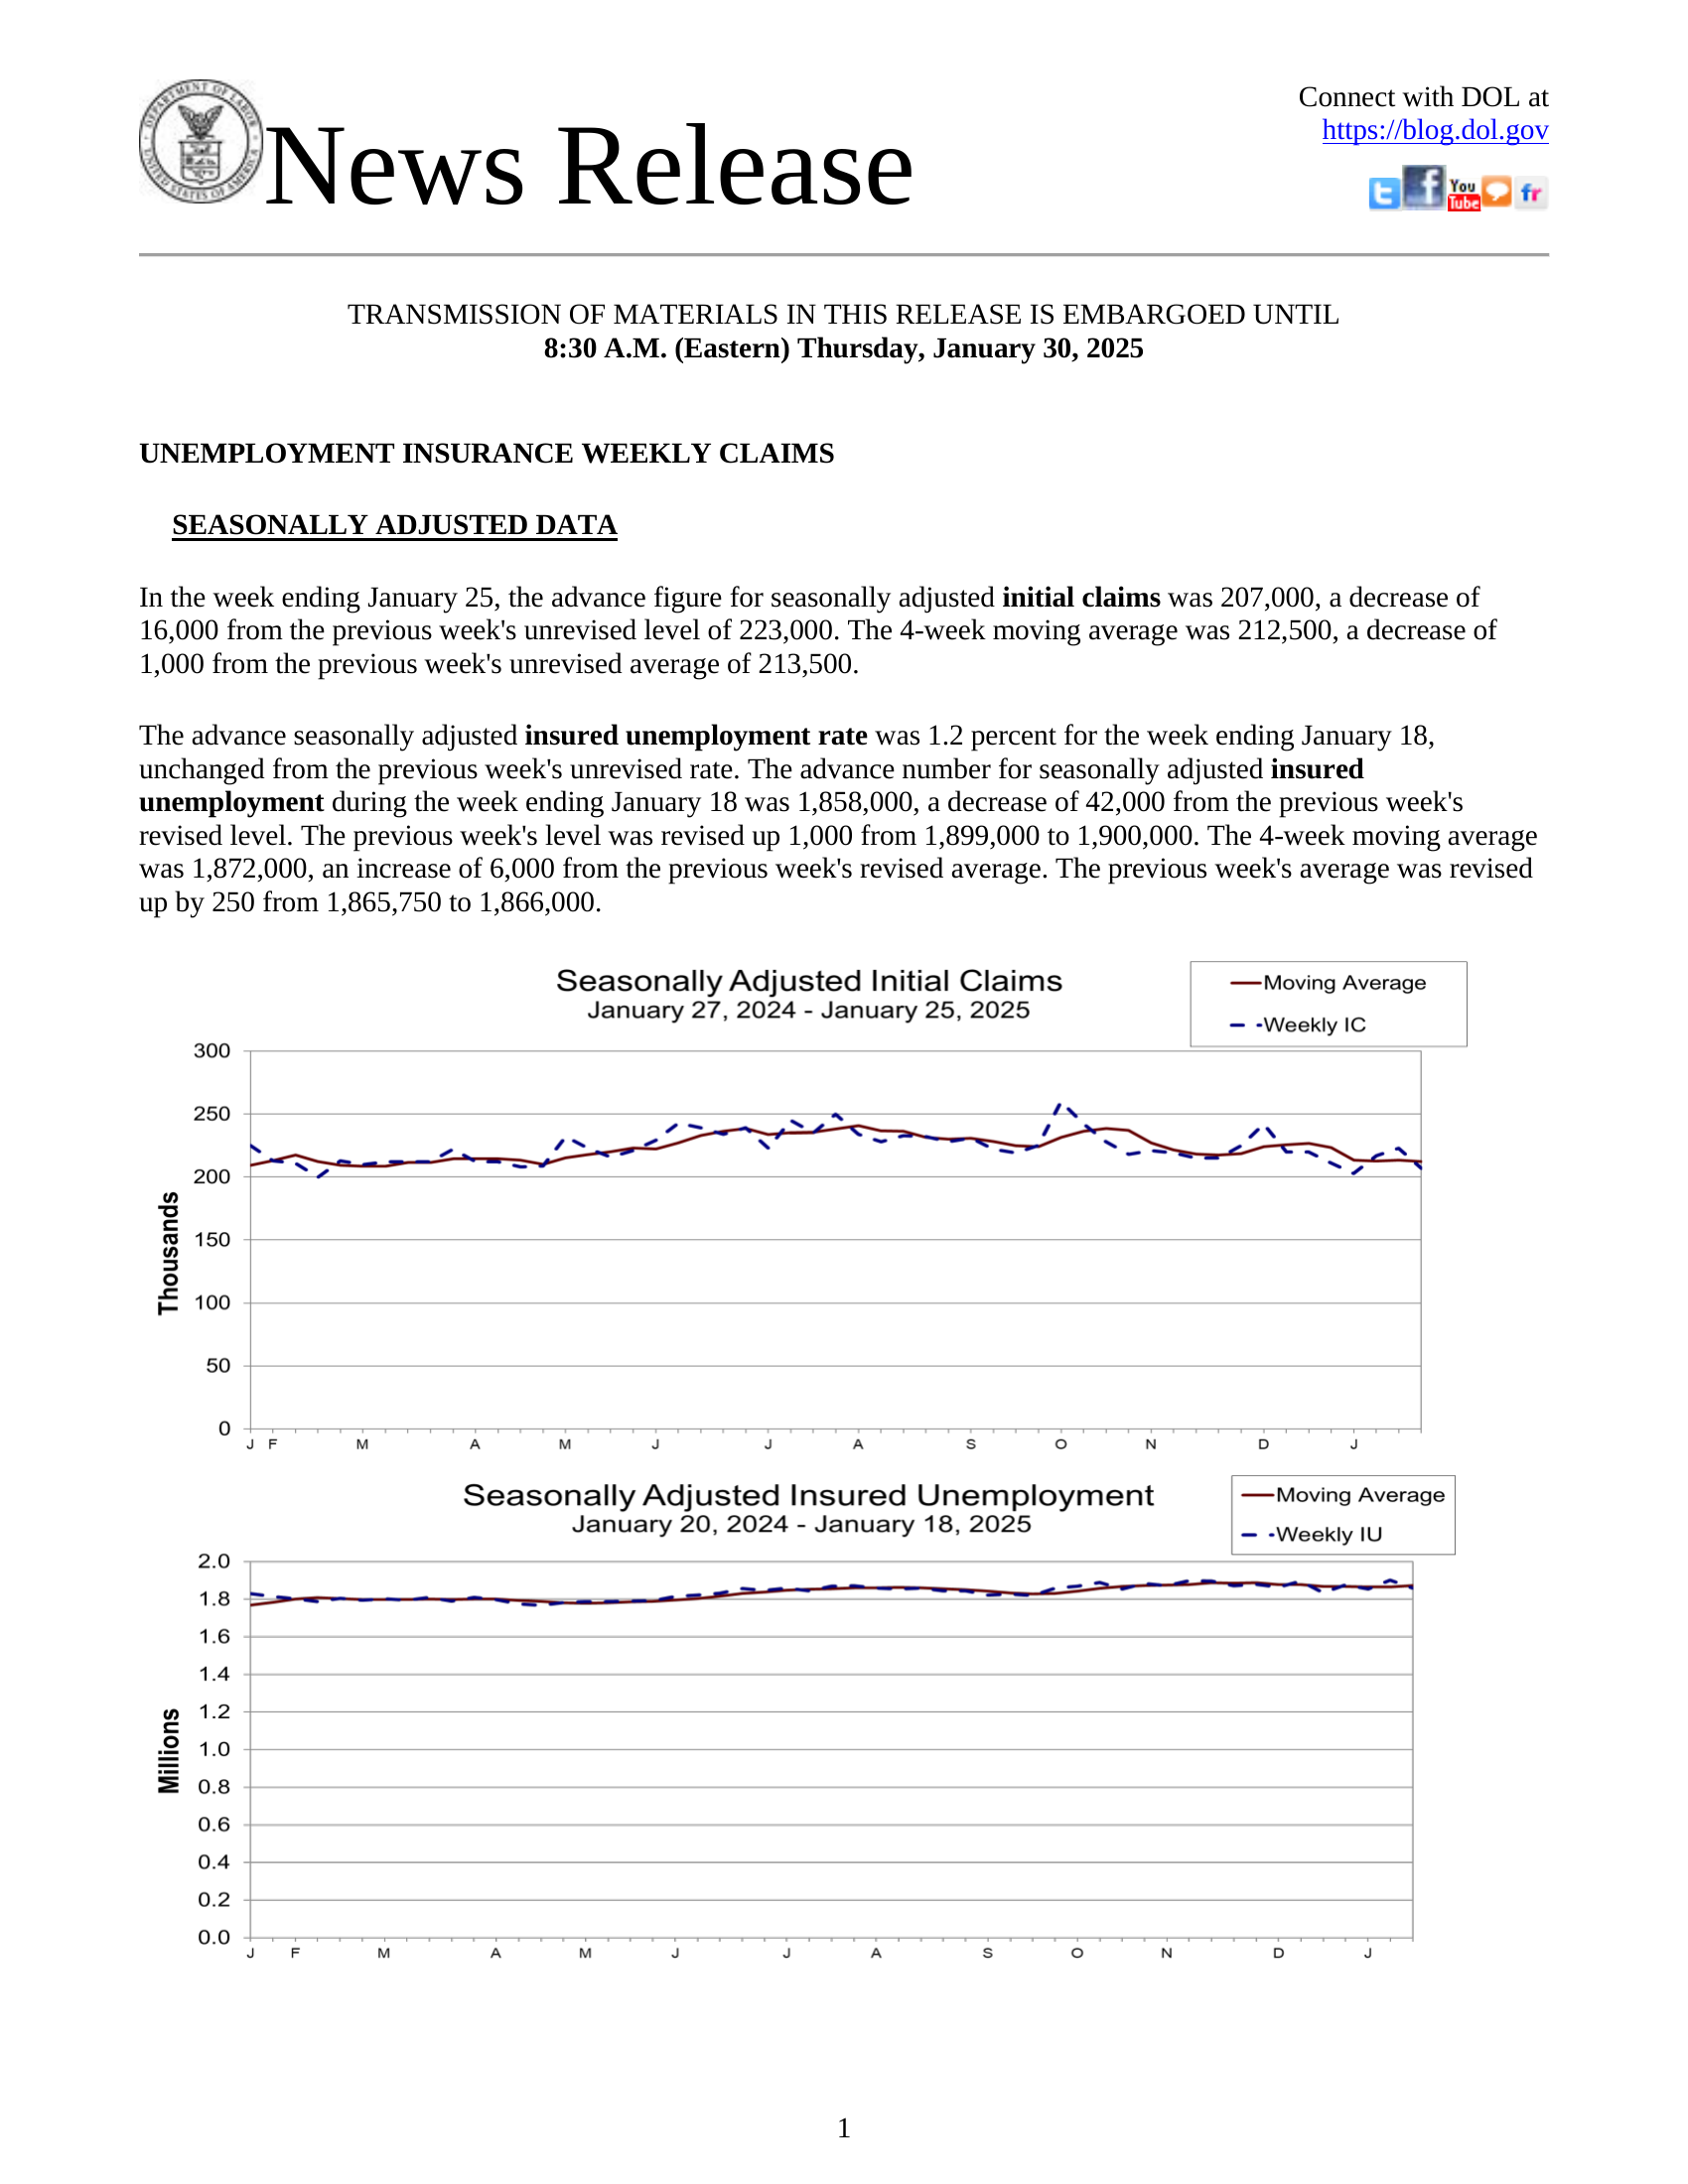

In [ ]:
multi_doc_images[0]

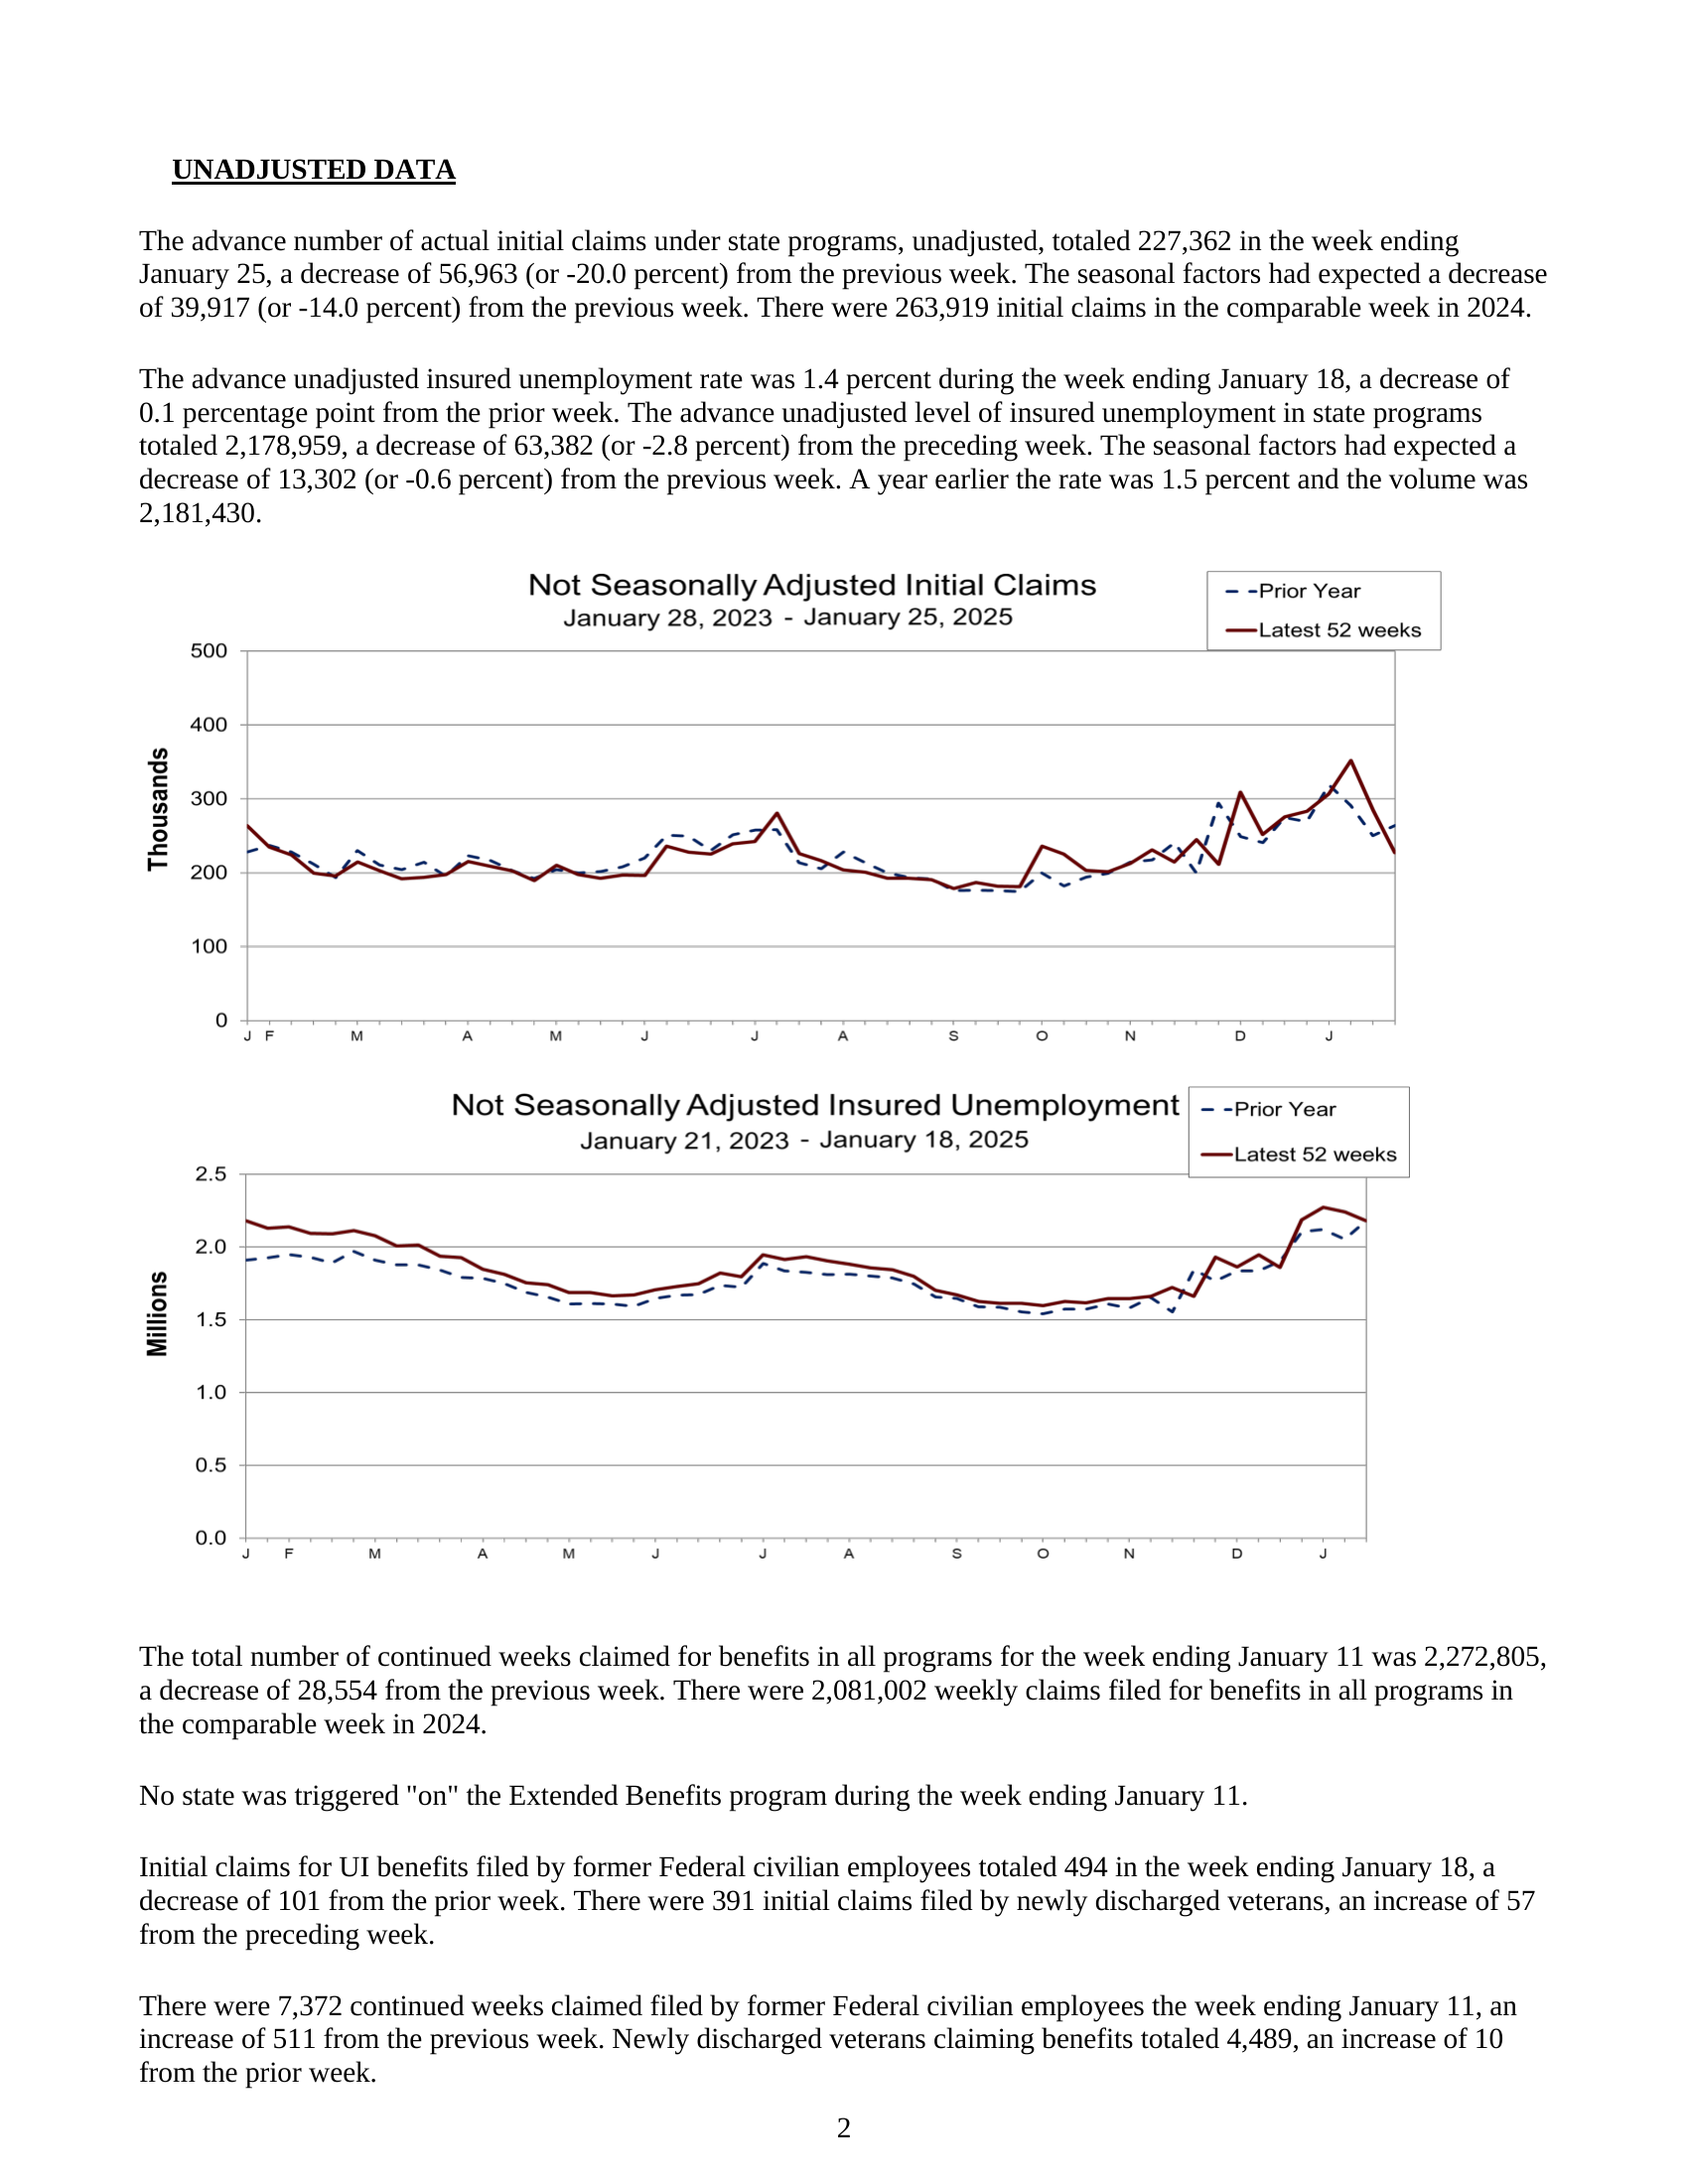

In [ ]:
multi_doc_images[1]

In [ ]:
print(multi_doc_answer)

The provided document presents data on unemployment insurance weekly claims, both seasonally adjusted and unadjusted, with accompanying line graphs to illustrate trends over time. Below is a detailed analysis of the differences between the seasonally adjusted and unadjusted charts:

### Seasonally Adjusted Claims (Chart 1)
- **Seasonally Adjusted Initial Claims**: The chart shows the number of initial claims that have been adjusted to remove the effects of seasonal variations.
- **Trend Analysis**:
  - The line graph indicates a relatively stable trend with slight fluctuations.
  - There is a noticeable dip around mid-year (around June), followed by a gradual increase towards the end of the year.
  - The moving average line smooths out these fluctuations, providing a clearer view of the underlying trend.
- **Key Observations**:
  - The seasonally adjusted data suggests a more consistent pattern compared to the unadjusted data, as it removes the distortions caused by seasonal factors.
 